In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import string
import warnings
warnings.filterwarnings('ignore')


In [3]:
#Initialise the train dataframe
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
#Initialise the test dataframe
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
"""
Concatenate both the train and test dataframes
The concat function takes in a list of dataframes
and the sort=True indicates that the new dataframe should have 
the order of the columns be alphabetically instead of the order in 
the original dataframe.
When two dataframes are concatanated by default the index is not reset
so setting ignore_index to True makes sure that the index is reset 
(goes from 0 to n - 1)
"""
df_all = pd.concat([df_train, df_test], sort=True, ignore_index=True)
 
dfs = [df_train, df_test]

In [4]:
"""
df_train['Cabin'] returns a Pandas Series for the column in the dataframe labelled 'Cabin'.
The function value_counts() returns a Series containing counts of unique values in the
Series (which in this case is the column 'Cabin'). value_counts() prints each the 
number of occurences of each unique value in the Series, starting from the 
most number of occurences to the least number of occurences. By default all null and 
n/a values are ignored
"""
df_train['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [5]:
"""
The isnull() method can be used with any datatype but for dataframes the function 
returns a dataframe of the same size except containing True or False values 
indicating whether a value in that specific location in the dataframe is True
or False. The .sum() function applied to a dataframe sums the value in each
column (the axis is column by default) and since True evaluates to 1 and False
evaluates to 0, in this scenario the sum basically is the number of True
values (or na values) in each column
"""
#prints the number of na values in each column
df_all.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [6]:
# Grouping Age with other columns like Sex and Pclass to obtain median wrt to the other columns.
"""
.groupby sorts the data based on the group 
"""
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

In [7]:
print(df_all.isnull().sum())
#replace the nan values in fare with the median
df_all["Fare"] = df_all["Fare"].fillna(df_all["Fare"].median())

Age               0
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


In [8]:
df_all["Cabin"] = df_all["Cabin"].fillna(0)
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        1309 non-null   object 
 2   Embarked     1307 non-null   object 
 3   Fare         1309 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None


In [9]:
"""
Apply one-hot encoding on the Cabin column (which adds more columns to the dataframe for each 
categorical value)
"""
df_forest = df_all.copy()
cabin_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
cabin_classes_dict = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7}
def replaceWithCabinClass(x):
    for cabin_class in cabin_classes:
        if cabin_class in str(x):
            return(cabin_classes_dict[cabin_class])
    return(0)
df_forest["CabinClass"] = df_forest["Cabin"].apply(replaceWithCabinClass)
#df_all = df_all.drop(["Cabin"], axis=1)
print(df_forest["CabinClass"].value_counts())
print(df_forest.info())

0    1015
3      94
2      65
4      46
5      44
1      22
6      18
7       5
Name: CabinClass, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        1309 non-null   object 
 2   Embarked     1307 non-null   object 
 3   Fare         1309 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
 12  CabinClass   1309 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 133.1+ KB
None


In [10]:
print(df_forest["Ticket"].value_counts())
"""
Drop ticket and column
Extract just the person's title (Dr, Mr, Ms) from the name (could be indicative of persons social class)
"""
def get_title(x):
    title = x[x.find(',') + 1 : x.find('.')]
    return title
df_forest_1 = df_forest.drop(["Ticket", "Cabin"], axis=1).copy()
df_forest_1["Name"] = df_forest_1["Name"].apply(get_title)
title_map = {}
ind = 0
for title in df_forest_1["Name"].value_counts().index:
    title_map[title] = ind
    ind += 1
df_forest_1["Name"] = df_forest_1["Name"].map(title_map)
print(df_forest_1["Name"].value_counts())

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: Ticket, Length: 929, dtype: int64
0     757
1     260
2     197
3      61
4       8
5       8
6       4
7       2
8       2
9       2
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
Name: Name, dtype: int64


In [11]:
print(df_forest_1["Embarked"].value_counts())
"""
Fill the 2 null values for the embarked column and then apply one-hot encoding on the other values
"""

embarked_encode = {'S':1,'C':2, 'Q':3}
df_forest_2 = df_forest_1.copy()
df_forest_2["Embarked"] = df_forest["Embarked"].fillna(0).apply(lambda x: embarked_encode[x] if x != 0 else 0)

S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [12]:
"""
Apply one hot encoding to the gender and survived column
"""

df_forest_3 = df_forest_2.copy()
df_forest_3["Sex"] = df_forest_3["Sex"].map({'male':0,'female':1})

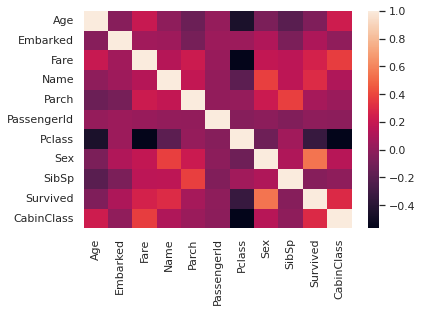

Age           -0.058635
Embarked       0.101849
Fare           0.257307
Name           0.296578
Parch          0.081629
PassengerId   -0.005007
Pclass        -0.338481
Sex            0.543351
SibSp         -0.035322
Survived       1.000000
CabinClass     0.295543
Name: Survived, dtype: float64


In [13]:
# Compute the pairwise correlations
corr = df_forest_3.corr()
# Generate a heatmap from the correlations
sns.heatmap(corr, annot=False, fmt='.2f', square=False)
# Show the plot
plt.show()
print(corr["Survived"])

# Fit Forest Regressor and Make Predictions
The hyperparameters were randomized and optimized using sklearn's RandomizedSearchCV. MAE and 5 fold seemed to work best so I stuck with that. While the model seems to be highly accurate this is due to basically using all of the data for training so the forest regressor most likely overfit, so instead I am using the actual accuracy after submitting to the public dataset to actually verify the accuracy of the model (it hovers around 45%)

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV

X = df_forest_3.drop(["Survived", "PassengerId"], axis=1).values
y = df_forest_3["Survived"].values

split = 890
X_train = X[:split]
y_train = y[:split]
X_test = X[split:891]
y_test = y[split:891]

# Create the random forest regressor
rf_model = RandomForestRegressor()

# Define the parameter values that you want to search
param_dist = {"n_estimators": [10, 50, 100, 200, 400, 600],
              "max_depth": [None, 5, 10, 20, 40, 60],
              "min_samples_split": [2, 5, 10, 20, 40, 60],
              "min_samples_leaf": [1, 2, 4, 8, 16, 30]}

# Create the random search object
random_search = RandomizedSearchCV(rf_model, param_dist, cv=5, scoring='neg_mean_absolute_error')

# Fit the model on the training data
random_search.fit(X_train, y_train)
rf_val_preds = random_search.predict(X[:891])
count1 = 0
total = 0
for pred, true in zip(rf_val_preds, y[:891]):
    if round(pred) == round(true):
        count1 += 1
    total += 1
print(count1/total)

0.9304152637485971


# Submit Predictions! Yay!

In [16]:
df_test = df_forest_3.drop(["Survived", "PassengerId"], axis=1).iloc[891:1309]
preds = [round(x) for x in random_search.predict(df_test.values)]
dictTemp = {'PassengerId':df_forest_3["PassengerId"].iloc[891:1309].astype(np.int32), 'Survived': preds}

df_submission = pd.DataFrame(data=dictTemp)
print(df_submission)
df_submission.to_csv('submission.csv', index=False)

      PassengerId  Survived
891           892         0
892           893         0
893           894         0
894           895         0
895           896         1
...           ...       ...
1304         1305         0
1305         1306         1
1306         1307         0
1307         1308         0
1308         1309         1

[418 rows x 2 columns]
